# 1. Fetch the data
Create a function to download the housing data from the internet.

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

Load the data through pandas.

In [2]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# 2. Examine the data
We would like to predict median house value with the other indicators.

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The `ocean_proximity` seems to be a classification field:

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

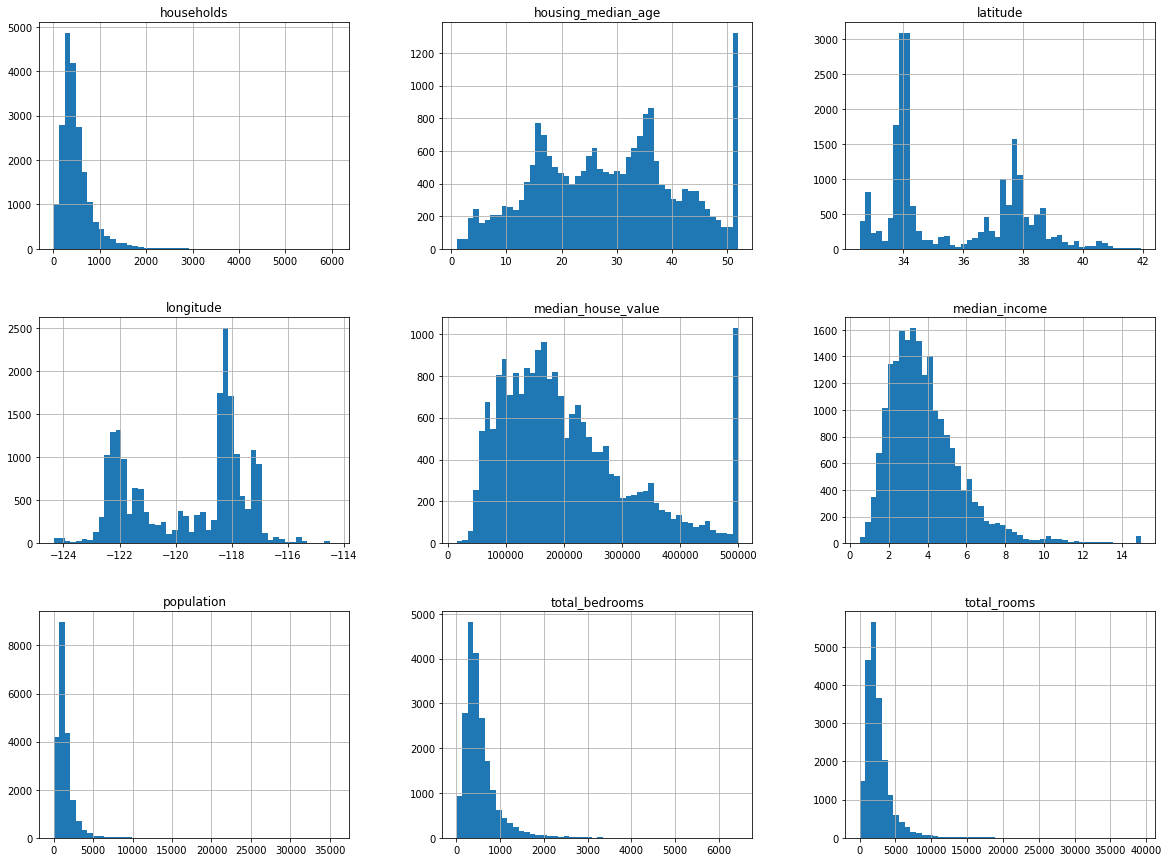

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

# 3. Split into test set and training set

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=16)

## Stratified Sampling 
To improve the test/training split, we would like to implement stratified sampling in terms of the `median income`.

First,we put the income data into 5 categories.

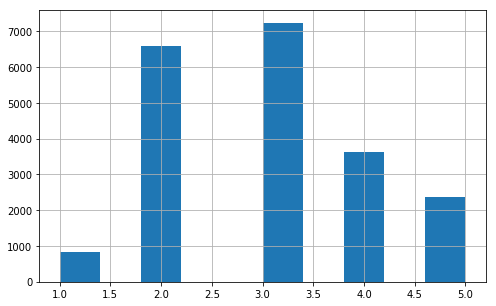

In [9]:
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3., 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist(figsize=(8,5))

Next, implement stratified split on the `income_cat`:

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=16)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To check if we have properly implemented strafified split, these ratios from the test set and the total dataset should match:

In [11]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [12]:
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

# 4. Study the trainig set, Visualize data
Make a copy the training set, and start to make some plots.

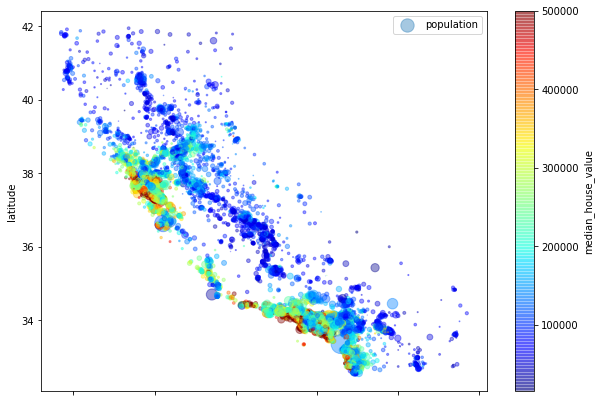

In [13]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.show()

### Looking for correlations 

In [14]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685987
total_rooms           0.130543
housing_median_age    0.102567
households            0.063758
total_bedrooms        0.047894
population           -0.025967
longitude            -0.042139
latitude             -0.147876
Name: median_house_value, dtype: float64

Alternatively, we can plot the scatter plots using `pandas.plotting.scatter_matrix`:

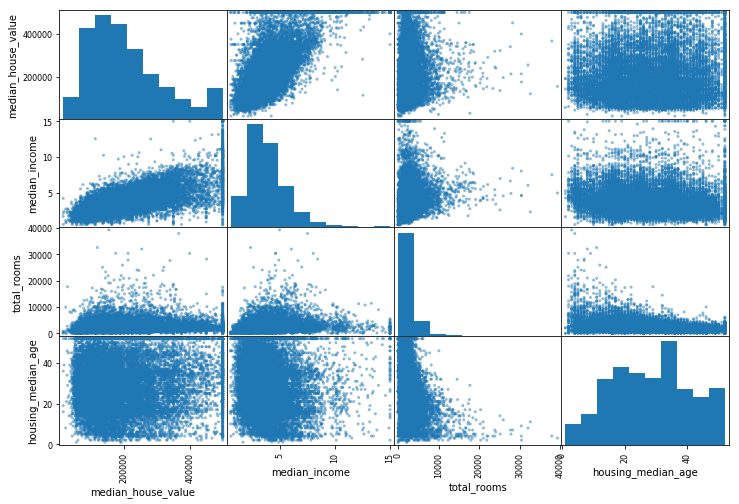

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

It seems that `median_income` and `median_house_value` has a strong correlation.
Also, observe the straight lines at $\$$ 500,000 and $\$$450,000. We may remove the corresponding districts to prevent the algorithms to learn from these data quirks.

### Attribute Combinations
Try to create new attributes and see how they work:

In [16]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [17]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.685987
rooms_per_household         0.147988
total_rooms                 0.130543
housing_median_age          0.102567
households                  0.063758
total_bedrooms              0.047894
population_per_household   -0.021822
population                 -0.025967
longitude                  -0.042139
latitude                   -0.147876
bedrooms_per_room          -0.251523
Name: median_house_value, dtype: float64

It seems that `bedrooms_per_room` has a large correlation with `median_house_value`, and it would be a great predictor to have for training our data.

# 5. Prepare the data for machine learning
Copy the training data sets and separate the predictors from the labels:

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
12961,-121.30,38.72,15.0,2514.0,482.0,1166.0,503.0,2.2813,INLAND,2
10194,-117.93,33.86,36.0,1672.0,318.0,1173.0,337.0,4.5774,<1H OCEAN,4
14544,-117.25,32.96,18.0,4773.0,743.0,1970.0,716.0,6.6199,NEAR OCEAN,5
7394,-118.25,33.95,48.0,1766.0,424.0,1655.0,420.0,0.9751,<1H OCEAN,1
14368,-117.24,32.73,37.0,2260.0,354.0,809.0,351.0,5.9113,NEAR OCEAN,4


### Data Cleaning
Fill in the missing data with median values.
(We could also `dropna()`, or `drop()` for the missing data.) 

In [22]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# imputer only works on numerical values
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [23]:
imputer.statistics_

array([-118.48  ,   34.25  ,   29.    , 2127.    ,  434.    , 1164.    ,
        409.    ,    3.5343,    3.    ])

In [27]:
housing_num.median().values

array([-118.48  ,   34.25  ,   29.    , 2127.    ,  434.    , 1164.    ,
        409.    ,    3.5343,    3.    ])

In [29]:
X = imputer.transform(housing_num)
# Or putting them into a Pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

### Handling Text/Categorical Attributes

1. Convert text to numbers using sklearn's `OrdinalEncoder`

In [31]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat = housing[['ocean_proximity']]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]

array([[1.],
       [0.],
       [4.],
       [0.],
       [4.]])

In [32]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

A better option for this case would be to use `OneHotEncoding`, where we use one-hot-vectors to represent category:

In [34]:
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder()

housing_cat_oh = oh_encoder.fit_transform(housing_cat)
housing_cat_oh.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

## Custom transformers 

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling 

Two ways:
- **Normalization** (min-max scaling): shift and rescale values from 0 to 1. Use `MinMaxScaler`
- **Standarization**: $ scaled = (value - \mu) / \sigma$, use `StandardScaler`
    + Less affected by outliers,
    + But may be a problem for some algorithms that only accepts value withiin 0-1 (eg. some neural networks)
    
### Transformation Pipelines
Use the `Pipeline` class to help with the tranformations:

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

To deal with numerical data and categorical data together, in version 0.20, Scikit-Learn introduced the `ColumnTransformer` and it also works great with Pandas DataFrames. Let’s use it to apply all the transformations to the housing data:

In [47]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

Now we have the `housing_prepared` ready for ML algorithms to train with!

Tip: Instead of a transformer, you can specify the string "`drop`" if you want the columns to be dropped. Or you can specify "`passthrough`" if you want the columns to be left untouched. By default, the remaining columns (i.e., the ones that were not listed) will be dropped, but you can set the remainder hyperparameter to any transformer (or to "passthrough") if you want these columns to be handled differently.